# Data Mining Versuch Analyse Globaler Gesundheitsdaten

* Autor: Prof. Dr. Johannes Maucher
* Datum: 18.10.2018

**Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen, den entsprechenden Ausgaben, Antworten und Diskussionen/Beschreibungen. Das Notebook ist als .ipynb und als .html abzugeben.**

* [Übersicht Jupyter Notebooks im Data Mining Praktikum](Data%20Mining%20Praktikum.ipynb)


# Einführung
## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Datenimport und Datenexport von und zu 
    * Pandas Dataframes
    * PostgreSQL Datenbanken
* Explorative Datenanalysen (EDA)
* Interaktive Datenvisualisierung mit Bokeh
* Dimensionsreduktion mit PCA und TSNE
* Überwachtes Lernen eines Regressionsmodells
* Unüberwachtes Lernen mit K-Means
* Zeitreihen-Visualisierung

## Vorbereitung

### Datenbankzugriff
1. Installieren Sie PostgreSQL. Mit PostgreSQL sollte auch pgAdmin installiert werden. PgAdmin ist eine open-source Software für die Entwicklung und die Administration von PostgreSQL Datenbanken.
2. Legen Sie über pgAdmin eine Datenbank für das Datamining-Praktikum an. In diese Datenbank werden alle in diesem Versuch relevanten Tabellen geschrieben.
3. Für den Datenbankzugriff aus Python heraus wird in diesem Versuch [SQLAlchemy](http://docs.sqlalchemy.org/en/latest/intro.html) eingesetzt. Machen Sie sich mit den Basics von SQLAlchemy vertraut, z.B. mithilfe von [https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb](https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb), Abschnitt *Using SQLAlchemy and Pandas*.

### Pandas Dataframe

Machen Sie sich mit den Grundlagen von Pandas vertraut.

### Visualisierung mit Bokeh

Machen Sie sich mit den Grundlagen von [Bokeh](https://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html) vertraut.

### Dimensionsreduktion
Machen Sie sich mit der Hauptachsentransformation (PCA) und dem t-SNE Verfahren vertraut.

### Regression

Machen Sie sich mit Linearer Regression und Random Forest Regression vertraut.

### Clustering

Machen Sie sich mit dem k-means Clustering Algorithmus vertraut.


# Durchführung

## Einlesen der Daten aus .csv und Ablage in PostgreSQL
In diesem ersten Teil des Versuchs müssen alle relevanten Daten aus .csv-Files eingelesen und in PostgreSQL-Tabellen abgelegt werden. Alle benötigten .csv Files befinden sich im Verzeichnis `gesundheitsdaten`. Die Daten stammen aus folgenden Quellen:

- allgemeine Daten pro Land und Jahr, wie:
    - Lebenserwartung (https://ourworldindata.org/life-expectancy)
    - BIP pro Kopf (https://ourworldindata.org/economic-growth)
    - Gesundheitsausgaben pro Kopf (https://ourworldindata.org/financing-healthcare)
    - Jahresarbeitsstunden pro Kopf (https://ourworldindata.org/working-hours)
- Ernährungsdaten pro Land und Jahr, wie: (https://ourworldindata.org/diet-compositions)
    - durchschnittliche zugeführte Kcal pro Kopf pro Tag für verschiedene Lebensmittel

### Allgemeine Daten
Das unten gegebene Dictionary `filenames_general` definiert aus welchen Dateien (keys), welche Spalten (values) gebraucht werden. Die Bezeichnung der Spalten in den Files weicht von der Spaltenbezeichnung im Dictionary ab. Die im Dictionary angegebenen Namen sollen aber in diesem Versuch (in den Pandas Dataframes und in den Datenbank-Tabellen) verwendet werden.

In [1]:
filenames_general = {'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'gdp-per-capita-worldbank.csv':['Entity','Code','Year','GDPperCapita'],
    'annual-healthcare-expenditure-per-capita.csv':['Entity','Code','Year','AnnualHealthcarExpPerCapita'],
    'annual-working-hours-per-persons-engaged.csv':['Entity','Code','Year','AnnualWorkingHourPerPerson']
}

1. Laden Sie die relevanten Daten dieser Files in einen Pandas Dataframe. Die Spalten des resultierenden Dataframes sind *Entity, Code, Year, LifeExpectancy, GDPperCapita, AnnualHealthcarExpPerCapita, AnnualWorkingHourPerPerson*. Als Keys sind *Code*, *Entity* und *Year* zu verwenden. Zeilen in denen mindestens einer dieser Keys fehlt, sind im Dataframe und in der Datenbank zu ignorieren.

> Tipp: Verwenden Sie für das Zusammenführen der Daten aus verschiedenen Files die Methode `merge()` des Pandas-Dataframes.

2. Zeigen Sie für den angelegten Dataframe 
    * die ersten 10 Zeilen
    * die Größe (Anzahl Zeilen und Anzahl Spalten)
    * die Anzahl der NaNs pro Spalte
    
an. 

3. Schreiben Sie den angelegten Dataframe mit der Pandas Methode `to_sql()` in eine Datenbanktabelle mit dem Namen `general_information`.

In [2]:
# All necessary imports 
import psycopg2 #provides drivers for PostgreSQL
import numpy as np
np.set_printoptions(precision=2,suppress=True)
import json #required to access json file
import pandas as pd
import geopandas as gpd
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# The code reads the contents of the .json file into a Python dictionary.
with open('../db/configLocalP1.json') as f:
    conf = json.load(f)

In [4]:
# Create connection string to connect to PostgreSQL database
from sqlalchemy import create_engine
conn_str ='postgresql://{}:{}@localhost:{}/{}'.format(conf['user'], conf['passw'], conf['port'], conf['database'])
engine = create_engine(conn_str)

In [5]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
general_information = pd.DataFrame
for key in filenames_general:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  general_information = pd.read_csv(csv_file, names=filenames_general[key], header=0)
  general_information = general_information.dropna(subset=['Code', 'Year']) # Drop missing values.
   
  # Plot the first rows, columns of the Pandas data frame
  #print('First lines in dataframe:\n{}'.format(general_information.head()))
  # Investigating over missing values
  #print('Information about dataframe:\n{}'.format(general_information.info()))
  #df[df['Code'].isnull()
     
  if result.empty:
     result = general_information
  else:
    result = result.merge(general_information, how='left', on=['Entity' ,'Code', 'Year'])
    #print('Merged result:{}'.format(result))

table_name = 'general_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already exists.'.format(table_name))


The table general_information already exists.


In [6]:
# Print 10 values to check 
print(result[:10])

# Number of rows
print('Total number of rows: {}'.format(result.shape[0]))

# Number of columns
print('Total number of columns: {}'.format(result.shape[1]))

# Investigating missing values 
print(result.isnull().sum(axis = 0))

        Entity Code  Year  LifeExpectancy  GDPperCapita  \
0  Afghanistan  AFG  1950       27.537001           NaN   
1  Afghanistan  AFG  1951       27.809999           NaN   
2  Afghanistan  AFG  1952       28.350000           NaN   
3  Afghanistan  AFG  1953       28.879999           NaN   
4  Afghanistan  AFG  1954       29.399000           NaN   
5  Afghanistan  AFG  1955       29.907000           NaN   
6  Afghanistan  AFG  1956       30.403999           NaN   
7  Afghanistan  AFG  1957       30.891001           NaN   
8  Afghanistan  AFG  1958       31.367001           NaN   
9  Afghanistan  AFG  1959       31.834000           NaN   

   AnnualHealthcarExpPerCapita  AnnualWorkingHourPerPerson  
0                          NaN                         NaN  
1                          NaN                         NaN  
2                          NaN                         NaN  
3                          NaN                         NaN  
4                          NaN               

In [7]:
# Test the results written into the database
#engine.execute("SELECT * FROM general_information").fetchall()

In [8]:
# Number of NaN values in every column.
result.isnull().sum(axis = 0)

Entity                             0
Code                               0
Year                               0
LifeExpectancy                     0
GDPperCapita                   10783
AnnualHealthcarExpPerCapita    11811
AnnualWorkingHourPerPerson     12067
dtype: int64

### Ernährungsdaten
Lesen Sie nun gleich wie oben die Ernährungsdaten ein. Die relevanten Spalten der entsprechenden Files sind nun im Dictionary `filenames_nutrition` definiert. Diese Daten sind in einer Datenbanktabelle `nutrition_information` anzulegen.

In [9]:
filenames_nutrition = {
    'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'fruit-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualFruitConsumptionPerCapita'],
    'vegetable-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualVegetableConsumptionPerCapita'],
    'dietary-compositions-by-commodity-group-1961-2013.csv':
            ['Entity','Code','Year','KcalOther','KcalSugar',
            'KcalOilsFats','KcalMeat','KcalDairyEggs',
            'KcalFruitsVegetables','KcalStarchyRoots','KcalPulses',
            'KcalCerealsGrains','KcalAlcoholicBeverages'],
    'daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv':
            ['Entity','Code','Year','KcalAnimalProtein',
            'KcalPlantProtein','KcalFat','KcalCarbohydrates'],
    'daily-per-capita-supply-of-calories.csv':['Entity','Code','Year','DailyCaloriesPerCapita']
}

In [10]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
nutrition_information = pd.DataFrame
for key in filenames_nutrition:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  nutrition_information = pd.read_csv(csv_file, names=filenames_nutrition[key], header=0)
  nutrition_information = nutrition_information.dropna(subset=['Code', 'Year']) # Drop missing values.

  # Plot the first rows, columns of the Pandas data frame
  print('First lines in dataframe:\n{}'.format(nutrition_information.head()))
  # Investigating over missing values
  print('Information about dataframe:\n{}'.format(nutrition_information.info()))
     
  if result.empty:
    result = nutrition_information
  else:
    result = result.merge(nutrition_information, how='left', on=['Entity' ,'Code', 'Year'])
    #print('Merged result:{}'.format(result))

table_name = 'nutrition_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already exists.'.format(table_name))


First lines in dataframe:
        Entity Code  Year  LifeExpectancy
0  Afghanistan  AFG  1950       27.537001
1  Afghanistan  AFG  1951       27.809999
2  Afghanistan  AFG  1952       28.350000
3  Afghanistan  AFG  1953       28.879999
4  Afghanistan  AFG  1954       29.399000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15386 entries, 0 to 17893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          15386 non-null  object 
 1   Code            15386 non-null  object 
 2   Year            15386 non-null  int64  
 3   LifeExpectancy  15386 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 601.0+ KB
Information about dataframe:
None
First lines in dataframe:
        Entity Code  Year  AnnualFruitConsumptionPerCapita
0  Afghanistan  AFG  1961                            41.13
1  Afghanistan  AFG  1962                            38.00
2  Afghanistan  AFG  1963                  

### Exemplarische Datenbankabfragen

1. Lesen Sie die Datenbanktabelle `general_information` in einen Pandas Dataframe.
2. Lesen Sie die Spalten `Year`und `AnnualWorkingHourPerPerson` für alle zu `Germany` gehörende Zeilen aus der Tabelle `general_information` in einen Pandas Dataframe.

> **Anmerkung:** Für diesen Versuch kommen relativ kleine Datenmengen zum Einsatz. In diesem Fall kann direkt auf den Pandas Dataframes gearbeitet werden. Für sehr große Datenmengen bietet es sich an, nicht alle Daten in den Arbeitsspeicher zu laden, sondern nur die aktuell benötigten durch entsprechende Datenbankabfragen. 

In [11]:
# Test the PostgrSQL database for specific entries
query="""SELECT "Entity","Code", "Year","AnnualWorkingHourPerPerson" FROM general_information WHERE "Entity"= 'Germany' """
gG=pd.read_sql_query(query,engine)
print(gG)

     Entity Code  Year  AnnualWorkingHourPerPerson
0   Germany  DEU  1875                         NaN
1   Germany  DEU  1885                         NaN
2   Germany  DEU  1895                         NaN
3   Germany  DEU  1905                         NaN
4   Germany  DEU  1911                         NaN
..      ...  ...   ...                         ...
70  Germany  DEU  2011                 1393.120038
71  Germany  DEU  2012                 1374.229772
72  Germany  DEU  2013                 1362.503252
73  Germany  DEU  2014                 1371.100896
74  Germany  DEU  2015                         NaN

[75 rows x 4 columns]


## Geographische Visualisierung der Lebenserwartung

In diesem Teilversuch soll die Lebenserwartung pro Land in einer Weltkarte visualisiert werden. Zu erstellen ist ein Plot der unten dargestellten Art:

![mapLifeExpext](Bilder/mapLifeExpect.png)

### Laden der länderspezifischen Polygondaten

1. Die Lebenserwartung pro Land soll auf einer Karte abgebildet werden. Hierfür werden zunächst die Länderumrisse benötigt, um diese plotten zu können. Die Daten dazu findet man z.B. hier: https://rawgit.com/johan/world.geo.json/master/countries.geo.json. Geodaten für die Länderumrisse können mithilfe der Python Library [geopandas](http://geopandas.org) wie folgt eingelesen werden.

In [12]:
import geopandas as gpd

# Path to the geographical data stored in a .json file
PATH = '../data/json/gesundheitsdaten_'
# Load data into GeoDataFrame
countries = gpd.read_file(PATH + 'countries_geo.json')

In [13]:
# Examine country GeoDataFrame loaded from .json file 
countries.head()

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


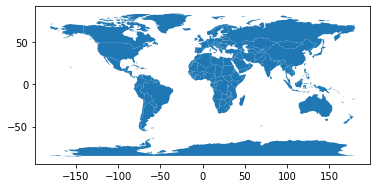

In [14]:
import descartes

# Test plot the countries with GeoPandas Descartes library
countries.plot()

1. Da in diesem Teilversuch nur die Lebenserwartung in 2015 betrachtet werden, sind nur diese Zeilen aus dem angelegten Dataframe zu berücksichtigen.
2. Vereinigen Sie die Polygondaten aus dem Dataframe `countries` mit dem Dataframe `general_information`. Achten Sie hierbei, dass Sie den *pandas dataframe* in den *geopandas dataframe* mergen, das Resultat also ein *geopandas dataframe* mergen ist (andernfalls funktioniert der nächste Schritt nicht). 

In [15]:
# Aufgabe 1:
# Query database to retrieve the data for life expectancy in the year 2015
query = """SELECT "Entity", "Code", "Year","LifeExpectancy" FROM general_information WHERE "Year"= '2015'"""
general_information_2015 = pd.read_sql_query(query,engine)

# Adjust names for the values of "Entity" and "Code" to "name" and "id"
general_information_2015.rename(columns={"Code":"id"}, inplace=True)
general_information_2015.count()
# Check the new values
print ('The new name-values are \n{}'.format(general_information_2015))


The new name-values are 
                  Entity        id  Year  LifeExpectancy
0            Afghanistan       AFG  2015       63.287998
1                Albania       ALB  2015       78.174004
2                Algeria       DZA  2015       75.860001
3                 Angola       AGO  2015       61.241001
4    Antigua and Barbuda       ATG  2015       76.207001
..                   ...       ...   ...             ...
198       Western Sahara       ESH  2015       69.212997
199                World  OWID_WRL  2015       71.429001
200                Yemen       YEM  2015       64.742996
201               Zambia       ZMB  2015       61.396999
202             Zimbabwe       ZWE  2015       60.397999

[203 rows x 4 columns]


In [16]:
# Merge the two dataframes into a GeoDataFrame
countriesMerged = countries.merge(general_information_2015, how='left', on=["id"])
#print('The merged GeoDataFrame values are \n{}'.format(countriesMerged))


5. Durch Aufruf der Methode `to_json()` kann ein Dataframe in json transformiert werden. Die von der Methode zurückgegebenen Daten können einem [Bokeh GeoJSONDataSource](https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html#geojson-data)-Objekt beim Anlegen übergeben werden. Das *GeoJSONDataSource*-Objekt kann direkt der entsprechenden Bokeh-plotting Funktion übergeben werden. Erzeugen Sie mit diesen Hinweisen einen interaktiven Weltkartenplot der oben dargestellten Art. Beim *Mouse-Over* über ein Land soll der Name des Landes und die Lebenserwartung angezeigt werden.
> Alternative: Eine einfachere Lösung für die Geovisualisierung bietet [geopandas](http://geopandas.org/mapping.html). Allerdings sind damit keine interaktiven Elemente realisierbar. 
6. Diskutieren Sie die aus der Visualisierung gewonnenen Erkenntnisse.

In [17]:
# Write the GeoPandaFrame to GeoJSON file format
countriesMerged.to_file("../data/json/lifeexp_geodata_2015.json", driver="GeoJSON")

In [18]:
# Import all required modules to render the interactive map in Bokeh
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import Viridis256
import json

### Bokeh Library for interactive maps
The merged files result in a _GeoDataframe_ object, which can be represented by using a geopandas module. For in interactive visualization _Bokeh_ library is used. Bokeh consumes _GeoJSON_ format, which represents geographical features with JSON. GeoJSON describes points, lines and polygones (_Patches_) as a collection of features. Therefore the merged files are converted to a GeoJSON format.

In [19]:
# Path to the geographical data stored in a .json file
#PATH = '../data/json/lifeexp_geodata_2015.json'
# Load GeoJson data from source
#data = gpd.read_file(PATH).to_json()
#print(data)

In [20]:
#GeoJSONDataSource Objekt erstellen
data = json.loads(countriesMerged.to_json())
# Convert the GeoJson data to a string-like object
geo_source = GeoJSONDataSource(geojson=json.dumps(data))

In [21]:
#Bokeh ausgabe im Notebook
output_notebook()

#Tooltip für Mouse-Over
TOOLTIPS = [
    ('Land', '@name'),
    ('Lebenserwartung', '@LifeExpectancy')
]

#Color Mapper für farbliche Visualisierung erstellen
Viridis256 = tuple(reversed(Viridis256))
color_mapper = LinearColorMapper(palette=Viridis256, low=countriesMerged.LifeExpectancy.min(), high=countriesMerged.LifeExpectancy.max())
color_mapper.low_color = "grey"

#Color bar als Legende
color_bar = ColorBar(color_mapper=color_mapper, 
                     label_standoff=12, border_line_color=None, location=(0,0))



#bokeh figure anlegen, mit zuvor erstelltem tooltip
p = figure (background_fill_color="lightgrey", plot_height = 600, plot_width= 1200, tooltips=TOOLTIPS)

#Länder hinzufügen mit farblich codierter Lebenserwartung
p.patches('xs', 'ys', source=geo_source, line_color="black", line_width=0.25, fill_alpha=1, fill_color = {'field' :'LifeExpectancy', 'transform' : color_mapper})

#Color bar der bokeh figure hinzufügen
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

# Ergebnis der Visualisierung

Auf der mittels Bokeh visualisierten Weltkarte sind die Lebenserwartungen je Land dargestellt. Hierbei werden die einzelnen Länder mit einer Farbskala von dunkel-lila bis hell-gelb eingefärbt. Je dunkler die Farbgebung, desto höher die Lebenserwartung.

Bei der Analyse der Weltkarte ist besonders auffällig, dass sowohl für Serbien, Somalia, Grönland, als auch Antarktika (sowie kleinere 
Inseln) keine Daten in der CSV Datei vorhanden sind. Diese werden hier grau dargestellt. Dagegen ist die Lebenserwartung in hauptsächlich westlichen Nationen, wie Japan (~ ca. 83 Jahre), Australien (~ ca. 82.7 Jahre), Kanada (~ ca. 82.5 Jahre), Neuseeland (~ ca. 81 Jahre), als auch Zentral-Europa am höchsten. Die niedrigste Lebenserwartungen sind vor allem in Zentral-Afrika (~ ca. 50 - 60 Jahre), Indien (~ ca. 68 Jahre), sowie Russland (~ ca. 70.9 Jahre), als auch dem Süden Asiens zu verzeichnen. 

Der Weltkarte nicht entnehmbar sind dabei politische, als auch gesellschaftliche Entwicklungen. Dennoch kann man aus dem Allgemeinwissen heraus schließen, dass sich die Geschichte u.A. Kolonialisierung der Länder in der Vergangenheit stark auf die Lebenserwartung und den Wohlstand in der Bevölkerung ausgewirkt hat. 

## Korrelation der Lebenserwartung mit volkswirtschaftlichen Metriken
In diesem Abschnitt soll die paarweise Korrelation von 
* `GDPperCapita`
* `AnnualHealthcarExpPerCapita`

mit der `LifeExpectancy` untersucht werden. 

1. Für die visuelle Korrelationsanalyse erzeugen Sie je einen Scatterplot, in dem `LifeExpectancy` über `GDPperCapita` bzw. über `AnnualHealthcarExpPerCapita` dargestellt ist.
2. Berechnen Sie mit der `numpy`-Funktion `corrcoef` die beiden paarweisen Korrelationen. 
3. Diskutieren Sie das Ergebnis.

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

# Additional Style elements
plt.rcParams['lines.linewidth'] = 3.5
plt.rcParams['lines.linestyle'] = '--'
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['axes.titlepad'] = 25
plt.rcParams['axes.labelpad'] = 20

#### Visual Correlation Analysis

### Berechnung des Korrelationskoeffizienten ( _Pearson Korrelation_ )
Der Korrelationskoeffizient wird auch als _Produkt-Moment-Korrelation_ benannt. Dies ist ein Maß für den Grad des linearen Zusammenhangs zwischen zwei mindestens intervallskalierten Merkmalen, das nicht von den Maßeinheiten der MEssung abhängt und somit dimensionslos ist. Dieser kann einen Wert zwischen ``` 1 ``` und ```-1 ``` annehmen. 

## Korrelation der Lebenserwartung mit Ernährungsdaten
Untersuchen Sie dann so wie im vorigen Abschnitt wie die einzelnen Nuitrition-Merkmale mit der `LifeExpectancy` korrelieren. Diskutieren Sie das Ergebnis.

## Time Series Analysis

Auf der Basis des Dataframes `nutrition_information`: Stellen Sie die zeitliche Entwicklung des Merkmals
1. `KcalFat` 
2. `DailyCaloriesPerCapita` 

von 1995 bis 2015 für die Länder Bolivia, Bulgaria, Egypt, Kenya, United States, China, Brazil, Germany graphisch dar. Erzeugen Sie hierfür pro Merkmal einen Plot, in dem die Linegraphs aller genannten Länder dargestellt sind. 

Interpretieren Sie diese Darstellungen

In [23]:
# Query the SQL database for 'KcalFat' as well as 'DailyCaloriesPerCapita'
query="""SELECT "Entity", "Code", "Year", "KcalFat","DailyCaloriesPerCapita" 
FROM nutrition_information WHERE "Year">= 1995 AND "Entity" IN ('Bolivia', 'Bulgaria', 'Egypt', 'Kenya', 'United States', 'China', 'Brazil', 'Germany') """
nutrition_information=pd.read_sql_query(query, engine)

# Equivalent to a database request
nutrition_information = nutrition_information[(nutrition_information['Year'] >= 1995)]
nutrition_information

,Entity,Code,Year,KcalFat,DailyCaloriesPerCapita
0,Bolivia,BOL,1995,399.42,2106.0
1,Bolivia,BOL,1996,423.99,2047.0
2,Bolivia,BOL,1997,424.44,2055.0
3,Bolivia,BOL,1998,378.18,1951.0
4,Bolivia,BOL,1999,381.06,2037.0
...,...,...,...,...,...
163,United States,USA,2011,1455.30,3649.0
164,United States,USA,2012,1460.07,3687.0
165,United States,USA,2013,1453.86,3682.0
166,United States,USA,2014,NaN,NaN


In [24]:
# List of countries for time series analysis
countries = nutrition_information['Entity'].unique()

# Data preprocessing to fill in NaN values with interpolation
result = pd.DataFrame()
# iterate through each selection
for country in countries:
    result = nutrition_information.loc[nutrition_information['Entity'] == country]
    nutrition_information.loc[nutrition_information['Entity'] == country] = result.fillna(result.interpolate(method='linear'))
    
# Analyse the tail of the dataframe
nutrition_information.tail(5)

,Entity,Code,Year,KcalFat,DailyCaloriesPerCapita
163,United States,USA,2011,1455.30,3649.0
164,United States,USA,2012,1460.07,3687.0
165,United States,USA,2013,1453.86,3682.0
166,United States,USA,2014,1453.86,3682.0
167,United States,USA,2015,1453.86,3682.0


In [25]:
#Persist data as CSV file
nutrition_information.to_csv(r'..\data\training\time_series\nutrition_information.csv', index = False, header=True)

In [26]:
# Convert column 'Year' to datetime for time-indexing
nutrition_information['Year'] = pd.to_datetime(nutrition_information['Year'], format='%Y', infer_datetime_format=True).dt.year
nutrition_information['Year']

0      1995
1      1996
2      1997
3      1998
4      1999
       ... 
163    2011
164    2012
165    2013
166    2014
167    2015
Name: Year, Length: 168, dtype: int64

In [27]:
# Indexing with time-series data to create datetime index
nutrition_information = nutrition_information.set_index(['Year'])

# Summary of the dataset
nutrition_information.isnull().sum()

Entity                    0
Code                      0
KcalFat                   0
DailyCaloriesPerCapita    0
dtype: int64

In [28]:
nutrition_information.head()

,Entity,Code,KcalFat,DailyCaloriesPerCapita
Year,,,,
1995,Bolivia,BOL,399.42,2106.0
1996,Bolivia,BOL,423.99,2047.0
1997,Bolivia,BOL,424.44,2055.0
1998,Bolivia,BOL,378.18,1951.0
1999,Bolivia,BOL,381.06,2037.0


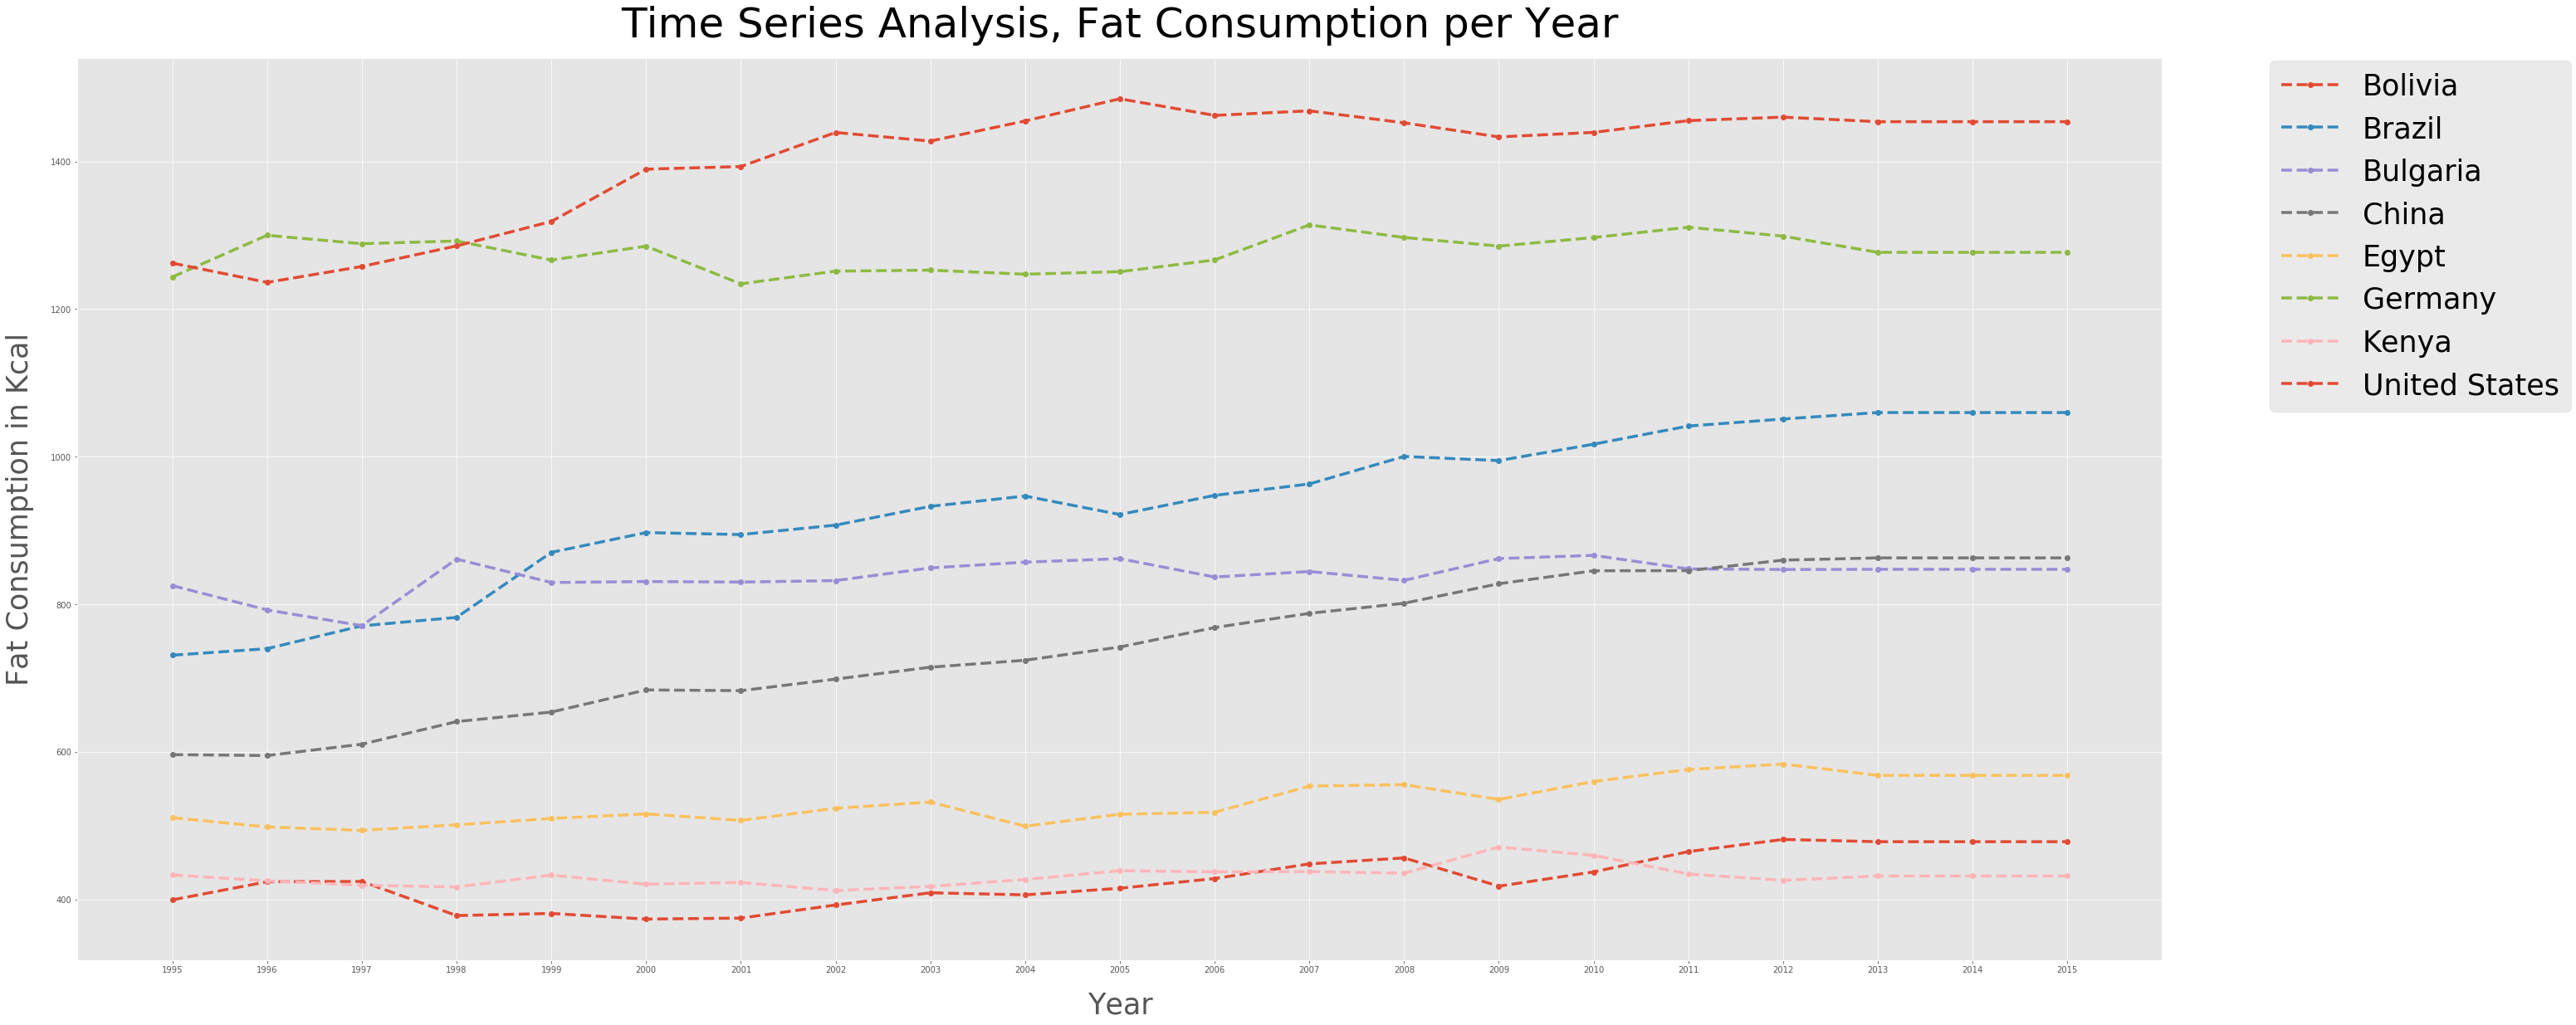

<Figure size 432x288 with 0 Axes>

In [29]:
"""
1. Graph: Fat Consumption per Year
- Draw a plot to check values in time series
"""
ax = plt.gca()
for country in countries:
    y = nutrition_information.loc[nutrition_information['Entity'] == country]
    y = y['KcalFat']
    y.plot(kind='line', xticks=y.index, figsize=(45, 20), grid=True, ax=ax)
    
plt.legend(countries, fontsize=35, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.xlabel('Year', fontsize=35)
plt.ylabel('Fat Consumption in Kcal', fontsize=35)
plt.title('Time Series Analysis, Fat Consumption per Year', fontsize=50)
plt.show()

# Store png
plt.savefig('../data/png/time_series_fatcons.png')

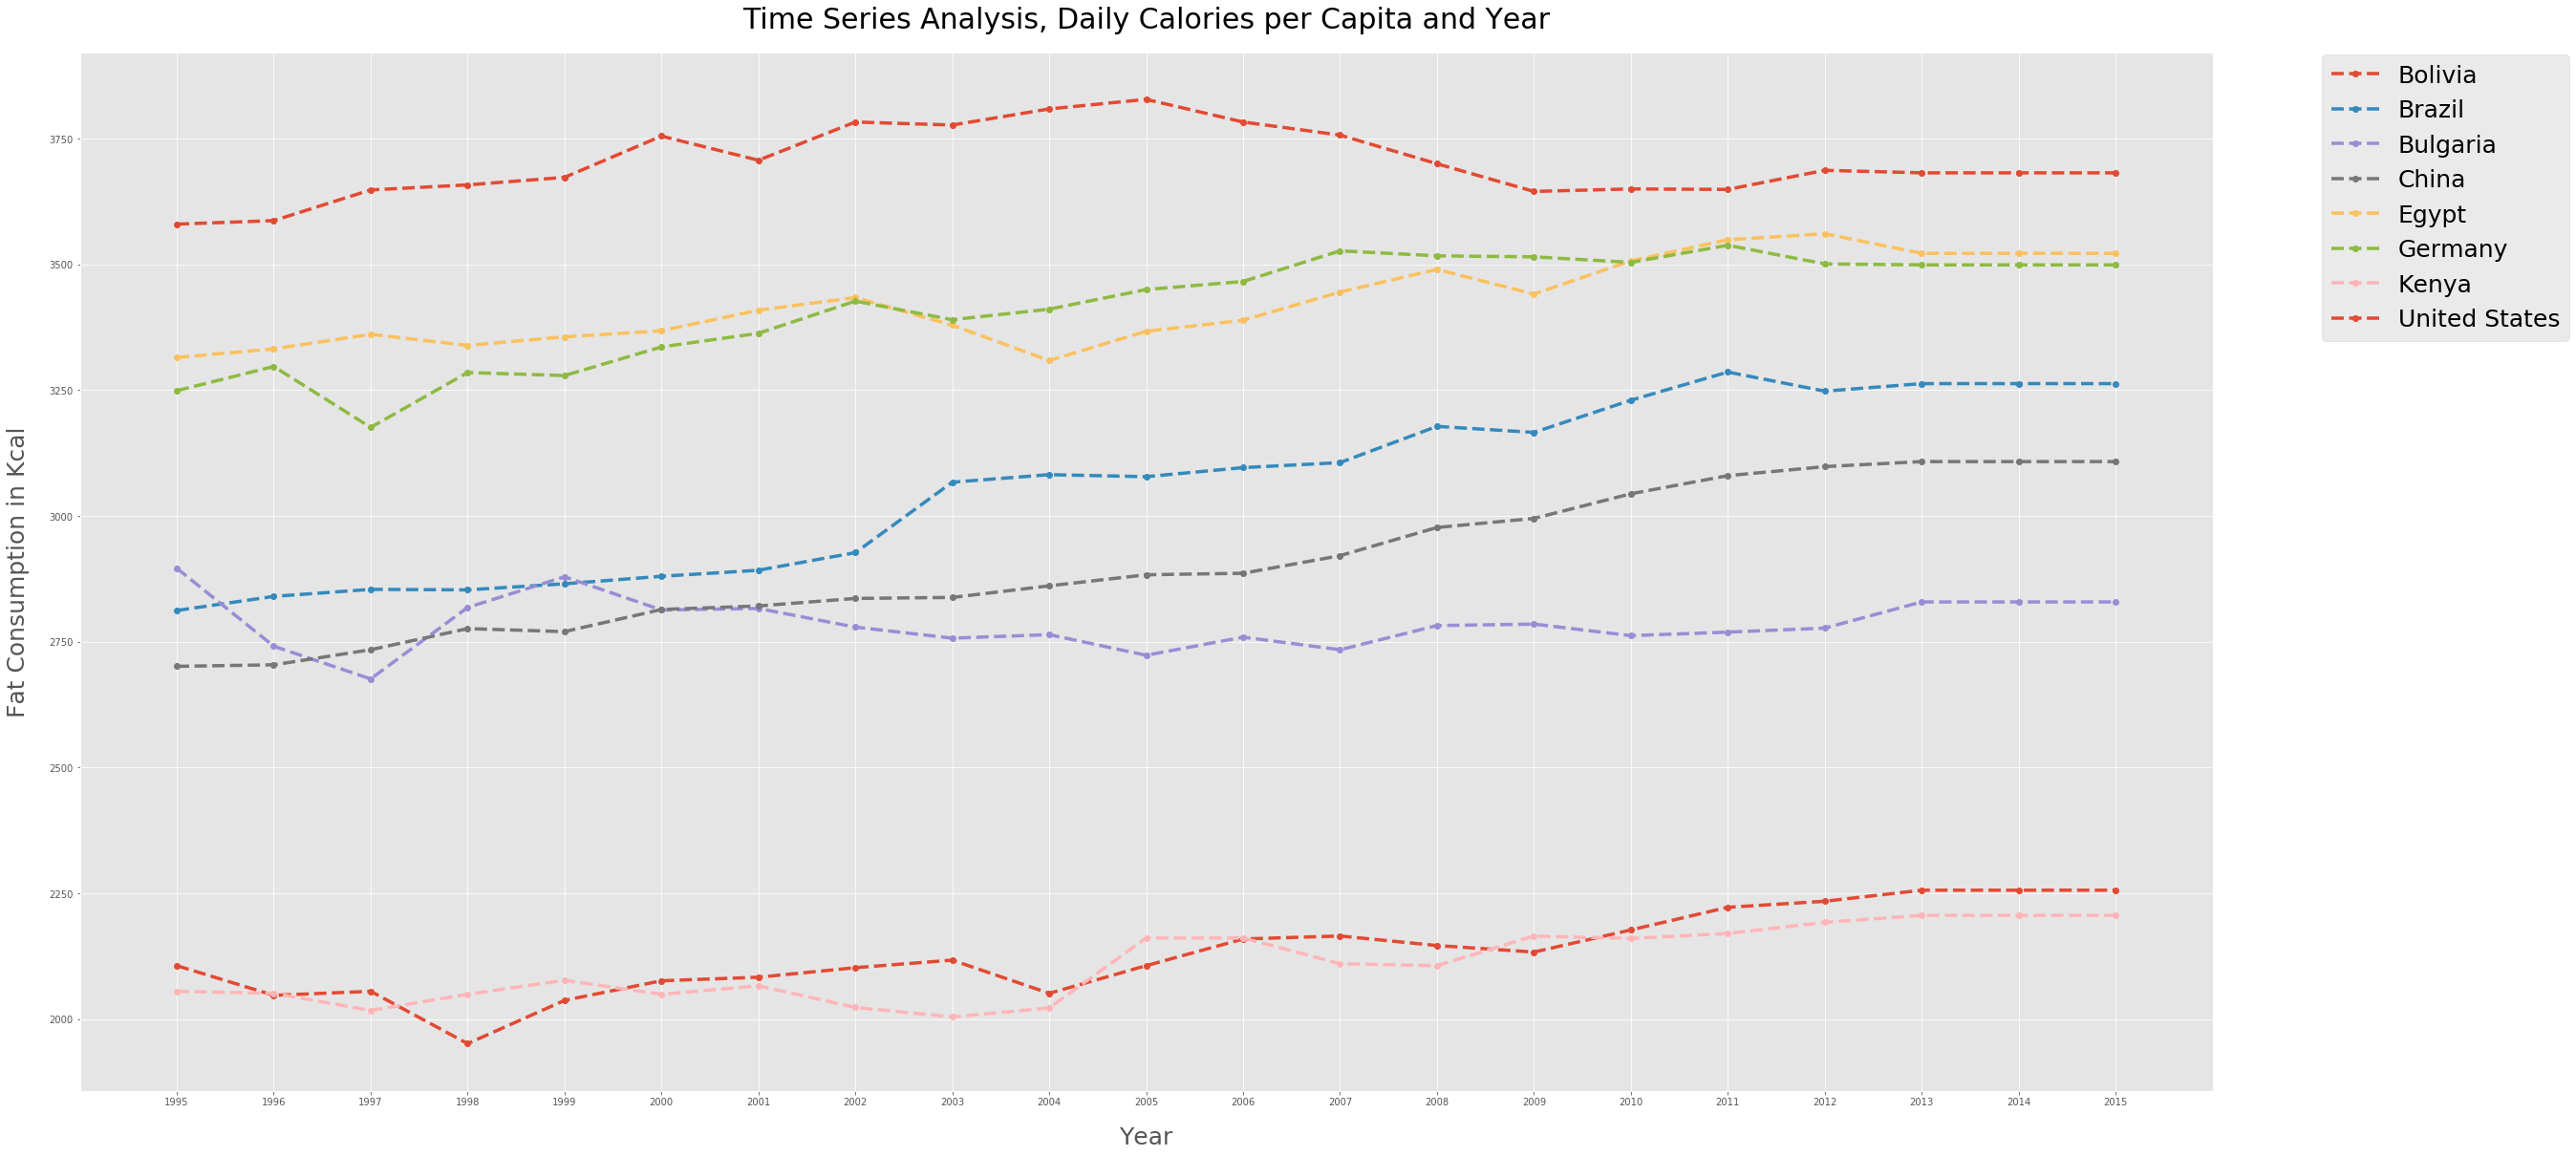

<Figure size 432x288 with 0 Axes>

In [30]:
"""
2. Graph:  Daily Calories per Capita and Year
- Draw a plot to check values in time series
"""

ax = plt.gca()
for country in countries:
    y = nutrition_information.loc[nutrition_information['Entity'] == country]
    y = y['DailyCaloriesPerCapita']
    y.plot(xticks=y.index, figsize=(40,20), grid=True, ax=ax)
plt.legend(countries, fontsize=25, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Fat Consumption in Kcal', fontsize=25)
plt.title('Time Series Analysis, Daily Calories per Capita and Year', fontsize=30)
plt.show()

# Store png
plt.savefig('../data/png/time_series_caloriespercap.png')

In [31]:
# Reset index
nutrition_information.reset_index(inplace=True)
nutrition_information

,Year,Entity,Code,KcalFat,DailyCaloriesPerCapita
0,1995,Bolivia,BOL,399.42,2106.0
1,1996,Bolivia,BOL,423.99,2047.0
2,1997,Bolivia,BOL,424.44,2055.0
3,1998,Bolivia,BOL,378.18,1951.0
4,1999,Bolivia,BOL,381.06,2037.0
...,...,...,...,...,...
163,2011,United States,USA,1455.30,3649.0
164,2012,United States,USA,1460.07,3687.0
165,2013,United States,USA,1453.86,3682.0
166,2014,United States,USA,1453.86,3682.0


# Interpretation der graphischen Darstellung

Die zu untersuchende, erste Grafik '_Time Series Analysis, Annual Fat Consumption (Kcal)_ ', als auch die zweite Grafik '_Time Series Analysis, daily Calories per Capita_' zeigen die Entwicklung des Kalorien- per Capita, als auch Fett Konsums, innerhalb verschiedener Länder, in Abhängigkeit der Zeit. Zur Untersuchung verschiedener Gesetzmäßigkeiten werden die Werte von acht, global verteilten Ländern herangezogen. Diese umfassen fünf Schwellenländer, die derzeit noch zu den globalen Entwicklungsländern zählen, sowie drei Industrie Nationen. Die Entwicklungsländer liegen im südamerikanischen Raum Bolivien, als auch Brasilien, sowie im Wirtschaftsraum EMEA mit Bulgarien und Ägypten. Dazu kommt Zentralafrika mit Kenya. Dem gegenüber stehen drei Industrienationen, sowohl im asiatischen Raum mit China, als auch zwei westlich Nationen aus Zentral Europa, sowie Nord Amerika mit Deutschland, sowie den Vereinigten Amerikanischen Staaten. Die dargestellten Werte haben einen jährlich wiederkehrenden Messzeitpunkt und verteilen sich über einen Zeitabschnitt von 20 Jahren zwischen den Jahren 1995 und 2015.

Bei der Analyse beider Grafiken ist insgesamt ein kontinuierlicher Aufwärtstrend erkennbar. Die Zeitreihen weisen langfristige Veränderungen in ihrem Niveau auf und sind damit nichtstationär. Gleichzeitig unterliegen die Zeitreihen innerhalb des Zeitraumes keinen saisonellen Entwicklungen. Sich wiederholende Entwicklungen innerhalb eines Jahres können in den vorliegenden Zeitreihendaten jedoch nicht ausgemacht werden, da für die Analyse (z.B.. bei saisonellen Schwankungen zwischen Sommer und Wintermonaten) die einzelnen Zeitangaben fehlen. Auch starke Ausreißer innerhalb der Zeitreihe, sowie zyklische Enwicklungen sind nicht erkennbar. 

In der ersten Grafik ist ein deutlicher Niveau Unterschied zwischen den verschiedenen Ländern erkennbar. So befinden sich die Industrienationen USA mit einem Mittelwert von 1403 Kcal/Jahr, sowie Deutschland mit einem Mittelwert von 1276 Kcal/Jahr am oberen Ende der Skala, während Bolivien mit einem Mittelwert von 426 Kcal/Jahr, neben Kenya mit 431 Kcal/Jahr, den geringsten Fett Konsum verzeichnet. Dies korreliert mit den Ergebnissen des pro Kopf Kalorienverbrauchs der zweiten Grafik. Die USA hat auch hier, dicht gefolgt von Deutschland mit 3415 Kalorien/Tag, den größten pro Kopf Verbrauch mit täglich 3701 Kalorien. Zum Vergleich benötigt ein Mann zwischen 25 und 51 Jahre durchschnittlich 2.400 Kalorien am Tag. Dies lässt darauf schließen, dass sowohl die deutsche, als auch die nordamerikanische Bevölkerung vermehrt an Adipositas, sowie Folgekrankheiten leidet. 

Auffällig ist bei Betrachtung von Unregelmäßigkeiten, dass seit dem Jahr 2005 eine negative Trendwende in den Industriestaaten, vor allem den USA statt gefunden hat. Während der Fettverbrauch pro Jahr nur leicht zurück ging, wurde der Kalorienverbrauch pro Kopf deutlich rückläufig. Bei nahezu allen Entwicklungsländern ging dagegen der Verbrauch insgesamt mit einem positiven Trend nach oben und man kann hier davon ausgehen, in Abhängigkeit der wirtschaftlichen Lage des jeweiligen Landes, dass sich dieser Aufwärtstrend auch in Zukunft weiter entwickeln wird. 

## Jahr mit den meisten non-Nans
1. Bestimmen Sie das Jahr, für das am meisten non-Nans in dem in der vorigen Teilaufgabe erstellten Dataframe `nutrition_information` existieren.
2. Erstellen Sie einen neuen Dataframe, der nur die non-Nan Daten für das zuvor bestimmte Jahr enthält.
3. Mergen Sie diesen neuen Dataframe mit dem Dataframe `general_information` ohne die Spalte `AnnualWorkingHourPerPerson`. Der so gebildete Dataframe wird im Weiteren mit `data_nut_gen` bezeichnet.

In [32]:
# Aufgabe 1

# Neues DataFrame das alle Jahre und die Anzahl der non-Nans in dieser Spalte enthält
df = pd.DataFrame()
df['Year'] = nutrition_information['Year']
df['non-Nan'] = nutrition_information.count(axis=1)   

# Dictionary in dem zu jedem Jahr die Anzahl an Non-Nan Spalten zugewiesen wird
Non_nans_count = {} 
non_nans_count = []

# Maximale Anzahl an Spalten die nicht Null sind
maximal = df["non-Nan"].max()

for label, row in df.iterrows():
    # Wenn die Anzahl an Non-Nan Spalten dem Maximum entspricht, wird es der Liste 'non_nans_count' angefügt
    if row[1] == maximal:
        non_nans_count.append(row[0])

# Für jedes Jahr wird gezählt wie viele Non-Nan Spalten in der Liste 'non_nans_count' enthalten sind 
for i in nutrition_information['Year'].unique():
    # Für jedes Jahr (=Key) wird die Anzahl (=Value) dem Dictionary 'Non_nans_count' zugewiesen
    Non_nans_count[i] = non_nans_count.count(i)
    
[k for k,v in Non_nans_count.items() if v == max(Non_nans_count.values())]

[1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [33]:
# Aufgabe 2
# Entscheidung fiel für das Jahr 2013

# Datenbankabfrage um alle Daten von der table 'nutrition_information' vom Jahr 2013 zu selektieren
query = """SELECT "Entity", "Code", "Year","LifeExpectancy","AnnualFruitConsumptionPerCapita", "AnnualVegetableConsumptionPerCapita",
"KcalOther","KcalSugar","KcalOilsFats" FROM nutrition_information WHERE "Year"= '2013'"""
df_2013 = pd.read_sql_query(query,engine)

# Datenbankabfrage um alle Daten außer 'AnnualWorkingHourPerPerson' von der table 'general_information' vom Jahr 2013 zu selektieren
query = """SELECT "Entity", "Code", "Year","LifeExpectancy","GDPperCapita","AnnualHealthcarExpPerCapita" FROM general_information WHERE "Year"= '2013'"""
general_information_2013 = pd.read_sql_query(query,engine)

In [34]:
# Aufgabe 3

# Merge vom DataFrame df_2013  und general_information_2013 
data_nut_gen = general_information_2013.merge(df_2013, how="left", on=["Entity","Code","Year","LifeExpectancy"])

# Löschen von noch vorhandenen NaN Spalten
data_nut_gen = data_nut_gen.dropna()

# Resetet Index weil diese nach dem drop lückenhaft sind
data_nut_gen.index = range(len(data_nut_gen))

## Dimensionsreduktion mit PCA und TSNE

Der oben konstruierte Dataframe `data_nut_gen` sollte ausschließlich non-NAN Werte haben und Daten nur eines Jahres enthalten. Alle Spalten von `data_nut_gen`, außer `Entity`, `Code`, `Year` und `LifeExpectancy` werden im Folgenden als *Merkmalsspalten* bezeichnet.

1. Führen Sie auf dem numpy-Array, das nur die Werte der *Merkmalspalten* enthält, eine Principal Component Analysis mit dem entsprechenden [scikit-learn Modul PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) durch. Bestimmen Sie die zwei Hauptachsen. 
2. Bestimmen Sie für das trainierte Modell den `explained_variance_ratio`. Was sagen diese Zahlen aus?
2. Stellen Sie die auf die 2 Hauptachsen transformierten Daten der Merkmalsspalten von `data_nut_gen` in einem Bokeh-Plot dar. In diesem soll die Farbe der Punkte durch die Werte der Spalte `LifeExpectancy` codiert werden.
3. Führen Sie nun eine Dimensionalitätsreduktion mit dem [scikit-learn Modul TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) auf 2 Achsen durch. Visualisieren Sie auch dieses Resultat mit einem Bokeh-Plot (wie in Teilaufgabe 2).
4. Diskutieren Sie das Ergebnis der beiden Dimensionsreduktionen.

In [35]:
import numpy as np
from sklearn.decomposition import PCA

In [36]:
# Aufgabe 1
import numpy as np
from sklearn.decomposition import PCA
features = ['GDPperCapita', 'AnnualHealthcarExpPerCapita', 'AnnualFruitConsumptionPerCapita', 'AnnualVegetableConsumptionPerCapita',
            'KcalOther', 'KcalSugar', 'KcalOilsFats']
X = data_nut_gen.loc[:, features].values
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

Df = pd.DataFrame(data = X_pca, columns = ['principal_component_1','principal_component_2'])

finalDf = pd.concat([Df,data_nut_gen['LifeExpectancy']], axis = 1)

original shape:    (161, 7)
transformed shape: (161, 2)


In [37]:
# Aufgabe 2

# explained_variance_ratio_ beider Hauptkomponenten
print('explained_variance_ratio_: ', pca.explained_variance_ratio_)

# explained_variance_ratio_ von Hauptkomponente 1
print('Hauptkomponente 1 explained_variance_ratio_: ', pca.explained_variance_ratio_[0])

# explained_variance_ratio_ von Hauptkomponente 2
print('Hauptkomponente 2 explained_variance_ratio_: ', pca.explained_variance_ratio_[1])

# Summe beider Komponenten
print('Summe beider Hauptkomponenten: ',pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])

explained_variance_ratio_:  [1. 0.]
Hauptkomponente 1 explained_variance_ratio_:  0.997459709075584
Hauptkomponente 2 explained_variance_ratio_:  0.0023852021409256786
Summe beider Hauptkomponenten:  0.9998449112165096


## Was sagen diese Zahlen aus?
'explained variance ratio' gibt an, wie viel Information (variance) den einzelnen Hauptkomponenten zugeordnet werden kann. Diese ist wichtig, da man z.B. einen 7-dimensionalen Raum in einen 2-dimensionalen Raum umwandeln kann, dabei aber etwas von der Varianz verliert. 
In unserem Beispiel hat die erste Hauptkomponente eine Varianz von ~99,75% und die zweite Hauptkomponente eine Varianz von ~0,24%. Daraus ergibt sich, dass beide Komponenten zusammen noch ~99,98% der Information enthalten. 


In [38]:
# Aufgabe 3

In [39]:
# Aufgabe 4

from sklearn.manifold import TSNE
X_TSNE = data_nut_gen.loc[:, features].values
X_embedded = TSNE(n_components=2).fit_transform(X_TSNE)
X_embedded.shape

print("original shape:   ", X_TSNE.shape)
print("transformed shape:", X_embedded.shape)

TSNE = pd.DataFrame(data = X_embedded, columns = ['principal_component_1','principal_component_2'])

Df_TSNE = pd.concat([TSNE,data_nut_gen['LifeExpectancy']], axis = 1)

original shape:    (161, 7)
transformed shape: (161, 2)


In [40]:
# Aufgabe 5

## Regression
Im Folgenden soll aus den Merkmalsspalten das Dataframes `data_nut_gen` die Lebenserwartung (Spalte `LifeExpectancy`) vorhergesagt werden.
1. Partitionieren Sie die Daten mit der [scikit-learn Methode](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), so dass $2/3$ der Daten für das Training und der Rest für den Test verwendet werden.
2. Trainieren Sie [ein lineares Regressionsmodell](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) mit den Trainingsdaten und bestimmen Sie den *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Linear-Regression Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
3. Trainieren Sie nun einen [Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) und bestimmen Sie wieder *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Random-Forest Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
4. Was ist der *R2-Score*?
4. Diskutieren Sie die Ergebnisse

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [42]:
# Investigation of data quality
data_nut_gen[data_nut_gen.isnull().any(axis=1)][:5]

,Entity,Code,Year,LifeExpectancy,GDPperCapita,AnnualHealthcarExpPerCapita,AnnualFruitConsumptionPerCapita,AnnualVegetableConsumptionPerCapita,KcalOther,KcalSugar,KcalOilsFats


Text(0.5, 1.0, 'Life Expectancy over Oil/Fat Consumption')

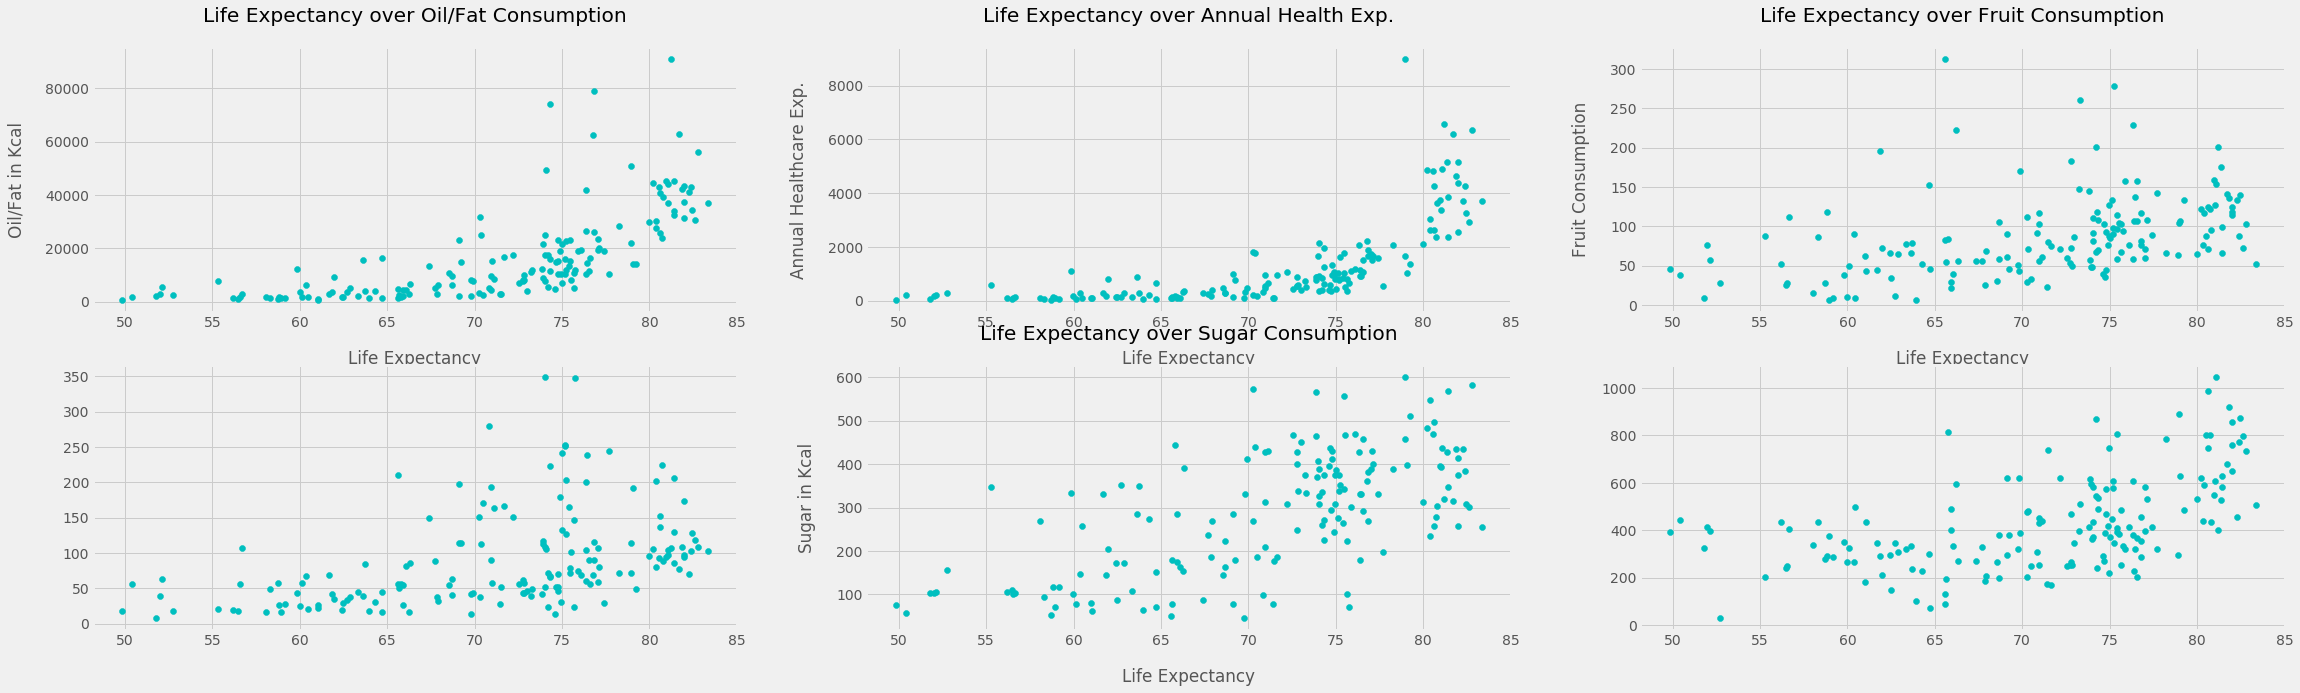

In [73]:
# Plott data distribution to check linearity
fig, axs =  plt.subplots(2,3, figsize=(35,10))

axs[0, 0].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.GDPperCapita, c='c')
axs[0, 0].set_xlabel('Life Expectancy')
axs[0, 0].set_ylabel('GDP per Capita')
axs[0, 0].set_title('Life Expectancy over GDP per Capita')

axs[0, 1].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.AnnualHealthcarExpPerCapita, c='c')
axs[0, 1].set_xlabel('Life Expectancy')
axs[0, 1].set_ylabel('Annual Healthcare Exp.')
axs[0, 1].set_title('Life Expectancy over Annual Health Exp.')

axs[0, 2].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.AnnualFruitConsumptionPerCapita, c='c')
axs[0, 2].set_xlabel('Life Expectancy')
axs[0, 2].set_ylabel('Fruit Consumption')
axs[0, 2].set_title('Life Expectancy over Fruit Consumption')

axs[1, 0].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.AnnualVegetableConsumptionPerCapita, c='c')
axs[0, 0].set_xlabel('Life Expectancy')
axs[0, 0].set_ylabel('Vegetable Consumption')
axs[0, 0].set_title('Life Expectancy over Vegetable Consumption')

axs[1, 1].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.KcalSugar, c='c')
axs[1, 1].set_xlabel('Life Expectancy')
axs[1, 1].set_ylabel('Sugar in Kcal')
axs[1, 1].set_title('Life Expectancy over Sugar Consumption')

axs[1, 2].scatter(x=data_nut_gen.LifeExpectancy, y=data_nut_gen.KcalOilsFats, c='c')
axs[0, 0].set_xlabel('Life Expectancy')
axs[0, 0].set_ylabel('Oil/Fat in Kcal')
axs[0, 0].set_title('Life Expectancy over Oil/Fat Consumption')


In [44]:
# 1. Aufgabe - Test train split data for supervised learning with Multiple Linear Regression

# Saving feature names for later use
feature_list = list(data_nut_gen.columns)
# X= multiple input variables, y = output variable 'LifeExpectancy'
X, y = data_nut_gen.iloc[:, 4:12], data_nut_gen.iloc[:, 3]
# Split training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # set to 42 means the results will be the same each time the split is run
# Split val and test data
y_val = train_test_split(y, shuffle=True)

In [45]:
# Check for dimensionalilty of split data
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (107, 7)
Training Labels Shape: (107,)
Testing Features Shape: (54, 7)
Testing Labels Shape: (54,)


In [46]:
# 2. Aufgabe 
# Define the multiple Linear Regression model and train it
lf_model = LinearRegression().fit(X_train, y_train)
# Predict the target values for the given features
y_pred = lf_model.predict(X_test)
# Plot prediction Array
print ('Predicted Life Expectancy per Country in Years: \n', y_pred)

Predicted Life Expectancy per Country in Years: 
 [85.93 62.78 72.5  71.66 70.41 75.64 64.07 69.06 60.76 60.8  68.51 75.18
 72.41 75.78 63.5  71.82 75.3  63.06 76.41 61.45 64.12 71.17 76.66 70.18
 76.64 99.01 63.82 72.04 78.45 86.45 69.18 68.64 63.17 67.   72.27 68.11
 59.44 73.28 76.6  73.37 84.59 92.33 62.65 66.48 69.73 73.87 76.21 69.86
 78.76 67.39 68.16 60.32 63.9  89.61]


In [47]:
# The coefficients
print('Coefficients: \n', lf_model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      %  mean_squared_error(y_test, y_pred))
# The mean absolute error
print('Mean absolute error: %.2f'
      %  mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


NameError: name 'model' is not defined

In [74]:
# 3. Aufgabe 
coeff_df = pd.DataFrame(lf_model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

NameError: name 'model' is not defined

#### Bedeutung (Wichtigkeit) der verwendeten Merkmale

Die Merkmale, welche einen hohen Einfluss auf das Ergebnis _y_ des Models haben können mittels deren Koeffizienten dargestellt und verglichen werden.
In der dargestellten Tabelle lässt sich ablesen, dass bei der Erhöhung eines Merkmals um eine Einheit sich der Output um den entsprechenden Wert erhöht, bzw. verringert. Bei der Erhöhung des Merkmals _x8_ _KcalOilFat_ um eine Einheit würde sich daher die _Lebenserwartung_ um ```0.001017``` verringern.

Insgesamt haben die Merkmale x5 _AnnualVegetableConsumptionPerCapita_,x7 _KcalSugar_, sowie x4 _AnnualFruitConsumptionPerCapita_ die größte Auswirkung und damit die höchste Bedeutung für den Output _y_.

In [49]:
# Aufgabe 4

# Random Forest Regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [50]:
# Instantiate model with 1000 decision trees
rf_model = RandomForestRegressor(n_estimators = 1000, max_depth=7, random_state = 42)
# Train the model on training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [51]:
# Use the forest's predict method on the test data
y_rf_pred = rf_model.predict(X_test)
# Calculate the absolute errors
errors = abs(y_rf_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'years.')

Mean Absolute Error: 3.23 years.


In [52]:
# The mean squared error
print('Mean squared error: %.2f'
      %  mean_squared_error(y_test, y_rf_pred))
# The mean absolute error
print('Mean absolute error: %.2f'
      %  mean_absolute_error(y_test, y_rf_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_rf_pred))

Mean squared error: 21.66
Mean absolute error: 3.23
Coefficient of determination: 0.65


In [53]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.1 %.


In [54]:
# Visualizing one tree of the forest in sklearn
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydotplus

In [62]:
# Pull out one tree from the forest
tree = rf_model.estimators_[5]
# Adjust freature list for labels
feature_list = [e for e in feature_list if e not in ('Entity', 'Code', 'Year', 'LifeExpectancy')]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, filled=True, rounded = True, precision = 1)
# Use dot file to create a graph
pydot_graph = pydotplus.graph_from_dot_file('tree.dot')

In [63]:
from IPython.display import Image

Image(pydot_graph.create_png())

InvocationException: GraphViz's executables not found

In [64]:
#5. Aufgabe

# Check for relative importance of the feature variables

# Get numerical feature importances
importances = list(rf_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: AnnualHealthcarExpPerCapita Importance: 0.78
Variable: GDPperCapita         Importance: 0.06
Variable: KcalOilsFats         Importance: 0.05
Variable: KcalSugar            Importance: 0.04
Variable: KcalOther            Importance: 0.03
Variable: AnnualFruitConsumptionPerCapita Importance: 0.02
Variable: AnnualVegetableConsumptionPerCapita Importance: 0.02


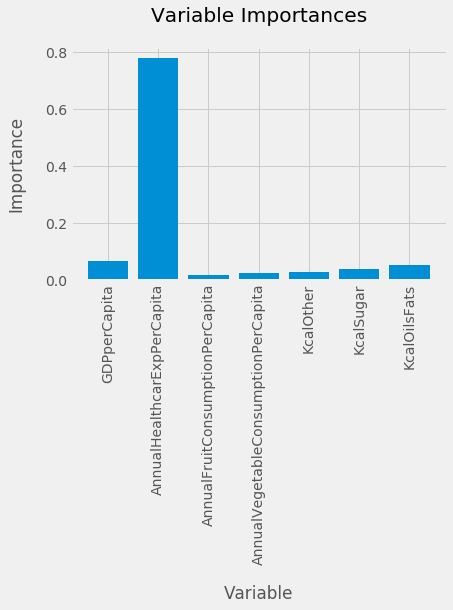

In [66]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

#### Bedeutung (Wichtigkeit) der verwendeten Merkmale

Untersuchung der Bedeutung von Merkmalsvariablen für die Performance des Models. Die mittels Skicit-Learn zurückgegebenen Werte der Bedeutsamkeit je Merkmal stellen dar, wie sehr die Einbeziehung einer bestimmten Variable die Vorhersage des _Random Forest Regression_ Algorithmus verbessert. Mittels den tabellarisch aufgelisteten Werten kann ein Vergleich zwischen den Merkmalsvariablen angestrebt werden.

Ganz oben steht dabei das Merkmal _AnnualHealthcareExpPerCapita_. Dies sagt aus, dass der beste Prädikator für die Lebenserwartung die jährlichen Ausgaben in das Gesundheitssystem eines Staates pro Kopf sind. Das zweit wichtigste Merkmal wird unter _GDPperCapita_ gelistet. Je höher das Bruttoinlandsprodukt (BPI) eines Landes ist desto höher der Wohlstand der Einzelpersonen und desto höher die Lebenserwartungen innerhalb einer Industrienation. Einen ebenso hohen Einfluss hat der Konsum von Ölen und Fetten auf die Lebenserwartung.

Dagegen haben der jährliche pro Kopf Frucht und Gemüse Konsum die geringste Bedeutung für die korrekte Vorhersage der jährlichen Lebenserwartung der Bevölkerung eines Landes. Bei zukünftigen Implementierungen des Modells können diese Variablen daher auch entfernt werden, ohne die Leistung des Algorithmus einzuschränken. 

## Clustering der Länder nach Ihrem Pro-Kopf-Kalorienverbrauch
1. Bestimmen Sie zunächst alle Länder für die das Merkmal `DailyCaloriesPerCapita` im Dataframe `nutrition_information` für alle Jahre von 1960 bis 2012 einen Wert hat. Konstruieren Sie dann ein numpy-Array $X$, in dem das Element $C_{i,j}$ in Zeile $i$, Spalte $j$, den `DailyCaloriesPerCapita`-Wert des Landes $i$ im $j.ten$ Jahr zwischen 1960 und 2012 enthält.
2. Clustern Sie die Länder nach ihrer zeitlichen Entwicklung des `DailyCaloriesPerCapita`-Wertes - also die Zeilen des Arrays $X$. Verwenden Sie hierfür den [K-Means Algorithmus von scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Stellen Sie dabei die Clusteranzahl auf $k=5$ ein. 
3. Für jedes der $k=5$ Cluster: Erzeugen Sie einen Plot, in dem der zeitliche Verlauf des `DailyCaloriesPerCapita`-Wertes aller zum jeweiligen Cluster gehörenden Länder als Line-Graph dargestellt ist.
4. Charakterisieren Sie die 5 Cluster anhand der clusterspezifischen Visualisierung.
    

In [ ]:
from sklearn.cluster import KMeans